# Lab Assignment 4: Solution

In [4]:
# import all libraries used for this assignment

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# use least_squares for FOPDT model fitting
from scipy.optimize import least_squares

# tclab functions
from tclab import TCLab, clock, Historian, Plotter, setup

# operating system library for creating data folder

The following cell consolidates choices for parameters values used throughout this notebook.

In [7]:
# parameters used throughout this notebook
P1 = 255
P2 = 50

# power levels used for step tests and performance evaluation
Q1 = 50
Q2 = 20

# time grid
t_step = 5
t_final = 1000

# tclab setup
connected = False
speedup = 20

# data files 
if not os.path.exists('data'):
    os.makedirs('data')
datafile_1 = os.path.join("data", "data_lab4_1.csv")
datafile_2 = os.path.join("data", "data_lab4_2.csv")

## Exercise 1. PI Control for T2 using Q1

The exerise comprises of two basic steps:

* Step 1: Step tests to identify FOPDT model for Q1 -> T2 dynamics. The same step test data will be used in exercise 2 for the Q1 -> T1 dynamics.
* Step 2: Estimate PI controller constants and implement antiwindup PI control.
* Step 3: Test controller for setpoint response and disturbance rejection.


### Step 1: Model Identification

#### Step Test

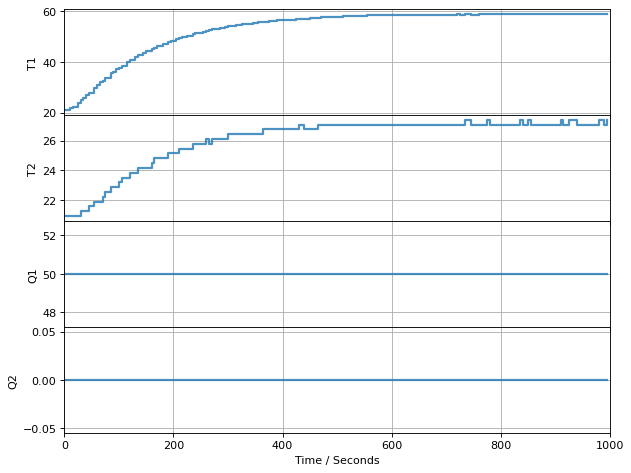

TCLab Model disconnected successfully.


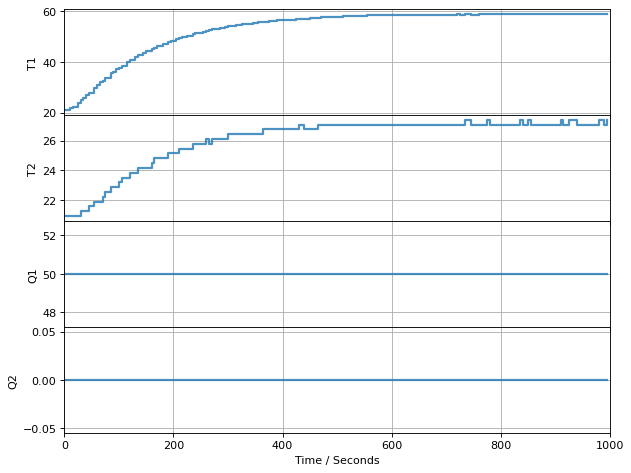

In [37]:
TCLab = setup(connected=connected, speedup=speedup if not connected else 1)
with TCLab() as lab:
    lab.P1 = P1
    lab.P2 = P2
    h = Historian(lab.sources)
    p = Plotter(h, t_final)
    lab.Q1(Q1)
    for t in clock(t_final, t_step):
        p.update(t)       
    h.to_csv(datafile_1)

#### Verify data set

    Time       T1       T2  Q1  Q2
0   0.00  20.9495  20.9495  50   0
1   5.00  20.9495  20.9495  50   0
2  10.13  21.5941  20.9495  50   0
3  15.14  22.2387  20.9495  50   0
4  25.05  23.8502  20.9495  50   0


<AxesSubplot:xlabel='Time'>

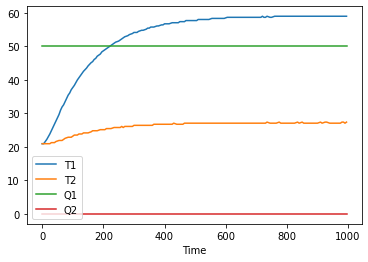

In [40]:
# load data file into a pandas dataframe
df = pd.read_csv(datafile_1)
print(df.head())

# plot data usinig "Time" as index
df = df.set_index("Time")
df.plot()

#### Fitting FOPDT Parameters for Q1 -> T2

We will need to fit at an FOPDT model at three times in the assignment. For that purpose we will take time to write a generic function that we can use for this purpose. The function accepts three array arguments: time t, manipulated variable MV, and process variable PV. The function requires MV to be constant.

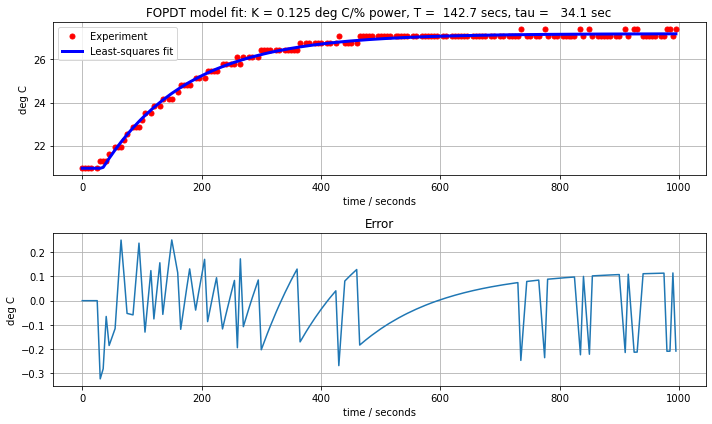

In [59]:
def fopdt_fit(t, MV, PV):
    
    assert all(MV.diff()[1:] == 0)

    def PV_pred(param):
        K, T, tau = param
        tau = max(0, tau)
        return PV[0] + MV.mean()*np.array([0 if t <= tau else K*(1-np.exp(-(t-tau)/T)) for t in t])
    
    K, T, tau = least_squares(lambda param: PV_pred(param) - PV, [1, 1, 1]).x
    
    fig, ax = plt.subplots(2, 1, figsize=(10,6))
    ax[0].plot(t, PV, 'r.', ms=10, label="Experiment")
    ax[0].plot(t, PV_pred((K, T, tau)), 'b', lw=3, label="Least-squares fit")
    ax[0].set_title(f"FOPDT model fit: K = {K:5.3f} deg C/% power, T = {T:6.1f} secs, tau = {tau:6.1f} sec")
    ax[0].set_xlabel("time / seconds")
    ax[0].set_ylabel("deg C")
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(t, PV_pred((K, T, tau)) - PV)
    ax[1].grid(True)
    ax[1].set_title("Error")
    ax[1].set_xlabel("time / seconds")
    ax[1].set_ylabel("deg C")

    plt.tight_layout()
    
    return K, T, tau

df = pd.read_csv(datafile_1)
K, T, tau = fopdt_fit(df["Time"], df["Q1"], df["T2"])

### Step 2: Controller implementation and testing

#### PI Implementation

We use the PI antiwindup implementation from notebook 3.5.

In [60]:
def PI_antiwindup(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        t_step, SP, PV, MV = yield MV
        e = PV - SP
        MV += -Kp*(e - e_prev) - t_step*Ki*e 
        MV = max(MV_min, min(MV_max, MV))
        e_prev = e

#### PI Controller Tuning

| Type | $K_P$ | $K_I$ |
| :---: | :---: | :---: |
| P (Ziegler-Nichols) | $\frac{T}{K\tau}$ | |
| PI (Astrom and Murray) | $\frac{0.15\tau + 0.35T}{K\tau}$ | $\frac{0.46\tau + 0.02T}{K\tau^2}$ |
| PI (Aggressvie IMC) | $\frac{T}{K(\tau + \max(0.1T, 0.8\tau)}$ | $\frac{1}{K(\tau + \max(0.1T, 0.8\tau)}$ |
| PI (ITAE Tuning) | $\frac{0.586}{K}\left(\frac{\tau}{T}\right)^{-0.916}$  | $\frac{1.03  -  0 .165\left(\frac{\tau}{T}\right)}{T}K_P$ |
| PI (Morari and Zafiriou) | $\frac{T + 0.5\tau}{1.7 K \tau}$ | $\frac{1}{1.7K}$ |
| PI (Ziegler-Nichols) | $\frac{0.9 T}{K\tau}$ | $\frac{0.3T}{K\tau^2}$ |


In [61]:
# Astrom and Murray Recommendations

def PI_params(params):
    K, T, tau = params
    Kp = (0.15*tau + 0.35*T)/(K*tau)
    Ki = (0.46*tau + 0.02*T)/(K*tau*tau)
    return Kp, Ki

Kp, Ki = PI_params((K, T, tau))
print(Kp, Ki)

12.92131486943079 0.12756435409710898


### Step 3: Controller Testing

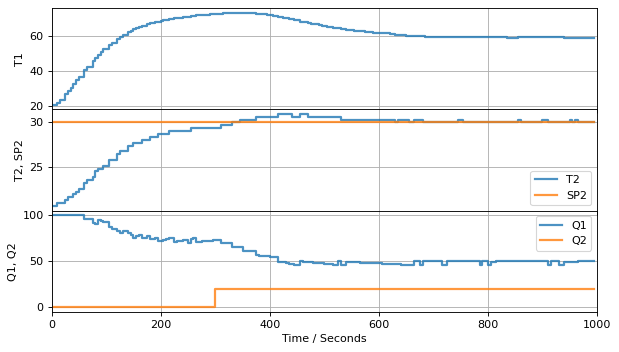

TCLab Model disconnected successfully.


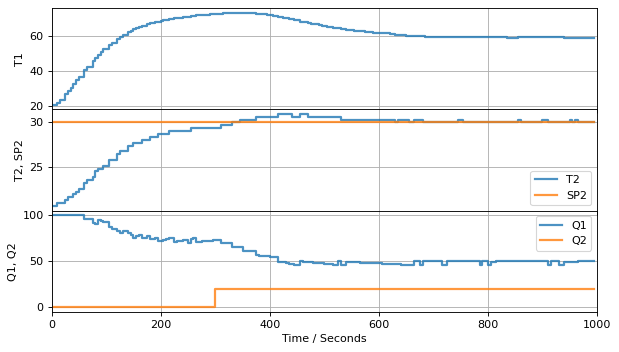

In [62]:
controller = PI_antiwindup(Kp, Ki, MV_min=0, MV_max=100)
next(controller)

# setpoint SP2
SP2 = lambda t: 30

# unmeasured disturbance
DV = lambda t: 20 if t >= 300 else 0

TCLab = setup(connected=connected, speedup=speedup if not connected else 1)
with TCLab() as lab:
    # set up historian and plotter
    lab.sources.append(('SP2', lambda: SP2(t)))
    h = Historian(lab.sources)
    p = Plotter(h, t_final, layout=(('T1',), ('T2', 'SP2'), ('Q1', 'Q2')))
    
    # set power levels
    lab.P1 = P1
    lab.P2 = P2
    
    for t in clock(t_final, t_step):
        lab.Q1(controller.send((t_step, SP2(t), lab.T2, lab.Q1())))
        lab.Q2(DV(t))
        p.update(t)

Examining the response of T2, it appears the controller is slow in approaching the steady state. This can be improved by increasing the integral action by increasing the value of $K_I$.

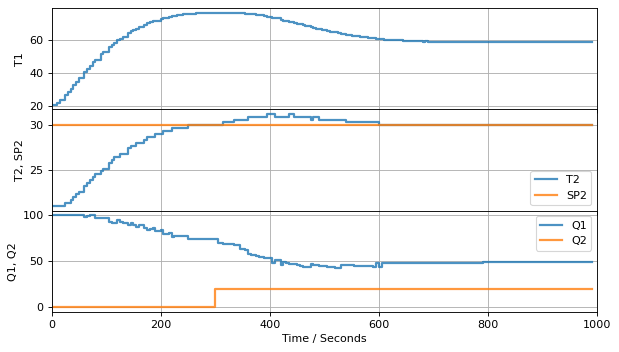

TCLab Model disconnected successfully.


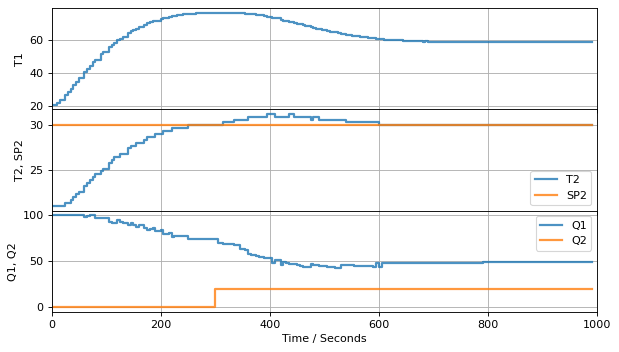

In [63]:
controller = PI_antiwindup(Kp, 1.4*Ki, MV_min=0, MV_max=100)
next(controller)

# setpoint SP2
SP2 = lambda t: 30

# unmeasured disturbance
DV = lambda t: 20 if t >= 300 else 0

TCLab = setup(connected=connected, speedup=speedup if not connected else 1)
with TCLab() as lab:
    # set up historian and plotter
    lab.sources.append(('SP2', lambda: SP2(t)))
    h = Historian(lab.sources)
    p = Plotter(h, t_final, layout=(('T1',), ('T2', 'SP2'), ('Q1', 'Q2')))
    
    # set power levels
    lab.P1 = P1
    lab.P2 = P2
    
    for t in clock(t_final, t_step):
        lab.Q1(controller.send((t_step, SP2(t), lab.T2, lab.Q1())))
        lab.Q2(DV(t))
        p.update(t)

## Exercise 2

The second exercise of the assignment can be broken into four steps:

* Step 1: Implement PI control for the inner control.
* Step 2: Step test the inner control loop for the response T2 to a step change in setpoint SP1.
* Step 3: Implement the outer controller.
* Step 4: Test the cascade control configuration.

### Step 1: Determining the Inner Controller

4.161373089567625 0.050281234666723434


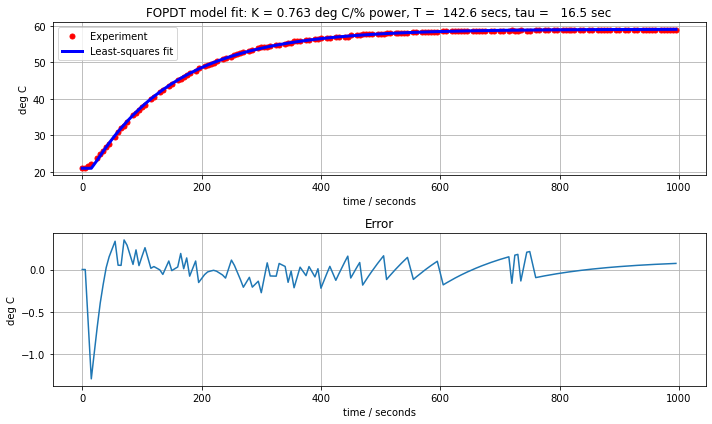

In [76]:
df = pd.read_csv(datafile_1)
Kp_inner, Ki_inner = PI_params(fopdt_fit(df["Time"], df["Q1"], df["T1"]))
print(Kp_inner, Ki_inner)

### Step 2: Step Testing the Inner Controller

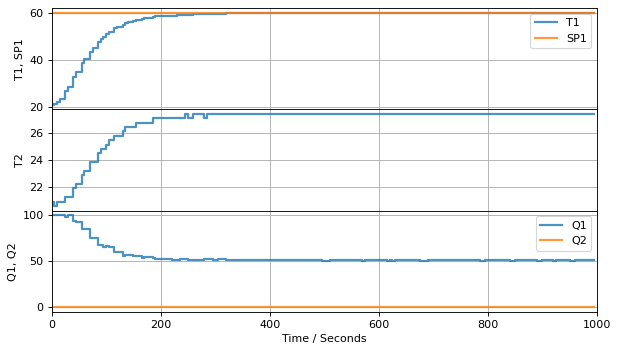

TCLab Model disconnected successfully.


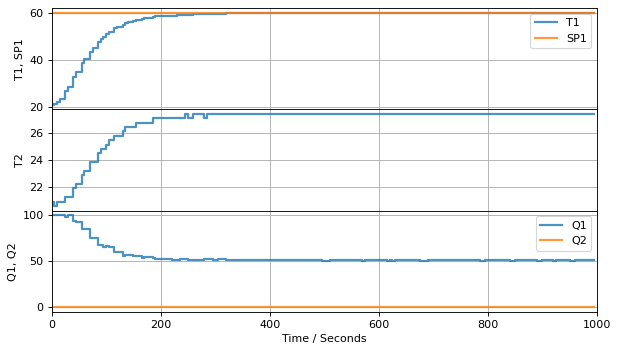

In [73]:
inner  = PI_antiwindup(Kp_inner, 1.4*Ki_inner, MV_min=0, MV_max=100)
next(inner)

# setpoint SP1
SP1 = lambda t: 60

TCLab = setup(connected=connected, speedup=speedup if not connected else 1)
with TCLab() as lab:
    # set up historian and plotter
    lab.sources.append(('SP1', lambda: SP1(t)))
    h = Historian(lab.sources)
    p = Plotter(h, t_final, layout=(('T1','SP1'), ('T2',), ('Q1', 'Q2')))
    
    # set power levels
    lab.P1 = P1
    
    for t in clock(t_final, t_step):
        lab.Q1(inner.send((t_step, SP1(t), lab.T1, lab.Q1())))
        p.update(t)
        
    h.to_csv(datafile_2)

### Step 3: Implement the Outer Controller

7.43233104193439 0.1404944729051455


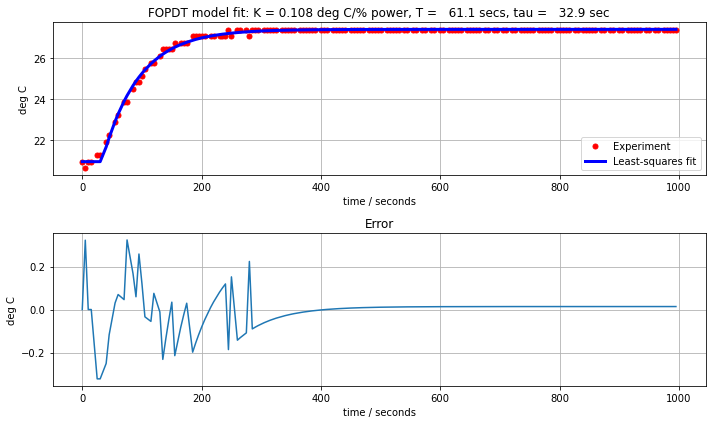

In [75]:
df = pd.read_csv(datafile_2)
Kp_outer, Ki_outer = PI_params(fopdt_fit(df["Time"], df["SP1"], df["T2"]))
print(Kp_outer, Ki_outer)

### Step 4: Test the Cascade Control Configuration

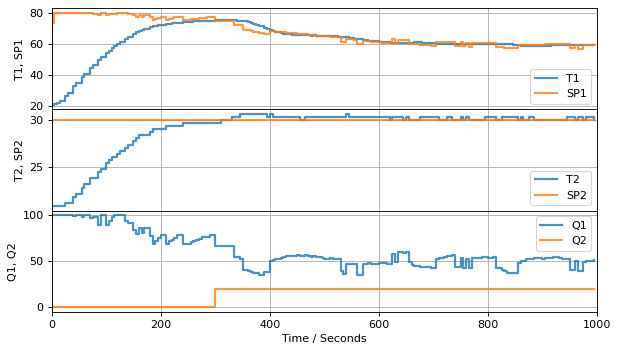

TCLab Model disconnected successfully.


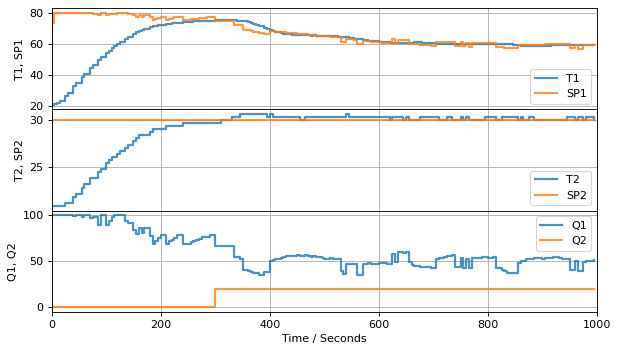

In [82]:
inner  = PI_antiwindup(Kp_inner, 1.4*Ki_inner, MV_min=0, MV_max=100)
next(inner)

outer = PI_antiwindup(Kp_outer, Ki_outer, MV_min=21, MV_max=80)
SP1 = next(outer)

# setpoint SP2
SP2 = lambda t: 30

# unmeasured disturbance
DV = lambda t: 20 if t >= 300 else 0

TCLab = setup(connected=connected, speedup=speedup if not connected else 1)
with TCLab() as lab:
    # set up historian and plotter
    lab.sources.append(('SP1', lambda: SP1))
    lab.sources.append(('SP2', lambda: SP2(t)))
    h = Historian(lab.sources)
    p = Plotter(h, t_final, layout=(('T1','SP1'), ('T2','SP2'), ('Q1', 'Q2')))
    
    # set power levels
    lab.P1 = P1
    lab.P2 = P2
      
    for t in clock(t_final, t_step):
        SP1 = outer.send((t_step, SP2(t), lab.T2, SP1))
        lab.Q1(inner.send((t_step, SP1, lab.T1, lab.Q1())))
        lab.Q2(DV(t))
        p.update(t)